In [16]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count(), device

(0, device(type='cpu'))

In [17]:
import os
import sys
IS_GCOLAB = 'google.colab' in sys.modules

In [18]:
from pathlib import Path

_base_libpath = Path(
    "/content/drive/MyDrive" if IS_GCOLAB else f"{os.environ['HOME']}"
) / "_self_research/24.09.world_cuisine"

print(_base_libpath)

assert _base_libpath.exists()

os.chdir(_base_libpath)

/home/is/frederikus-h/_self_research/24.09.world_cuisine


In [19]:
if IS_GCOLAB:
    raise NotImplementedError()
    # from google.colab import drive
    # drive.mount('/content/drive')

else:
    print(">>> Not on Google Colab <<<")

>>> Not on Google Colab <<<


---

In [20]:
# import datasets
# from datasets import load_dataset
# from torch.utils.data import DataLoader
# from sentence_transformers import SentenceTransformer

import os
import requests
import pickle
from PIL import Image
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
from tqdm import tqdm

import re
import json
from collections import Counter

---

In [21]:
df_all = pd.read_csv("resources/WorldCuisines - Food.2410032035.tsv", sep="\t")
df_w_reg = df_all[df_all.loc[:,'Region1'].notna()].reset_index(drop=True)
foodnames = pd.read_csv("resources/food_name_multiling.csv", index_col=0).rename({"Name": "Name_old"}, axis=1)

In [22]:
df = df_w_reg[df_w_reg.loc[:,"Coarse-grained categories"].notna()&df_w_reg.loc[:,"Cuisines"].notna()&df_w_reg.loc[:,"Text Description"].notna()]
df = df.merge(foodnames, on="Wikipedia Link")

In [23]:
df.loc[:,"json_aliases"] = df.apply(
    lambda r: {
        k.split(" - ")[0]: v
        for k, v in [("en - English", r.Name),
                     *list(json.loads(r.json_aliases).items())]
    },
    axis=1
)

In [24]:
def get_img(fp):
    headers = {'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org)'}
    try:
        if fp.startswith("https://"):
            response = requests.get(fp, headers=headers, stream=True, timeout=8)
            response.raise_for_status()
            _img = response.raw
        else:
            _img = _base_libpath / "images" / fp
        image = Image.open(_img).convert('RGB')
        return image
    except Exception as e:
        # print(fp, e)
        return None

In [25]:
values = pd.read_csv("resources/WorldCuisines - Location&Cuisine.2410040309.csv", header=[0, 1])
templates = pd.read_csv("resources/WorldCuisines - Query & Context.2410040242.tsv", sep='\t').iloc[:,2:]
templates_adverse = templates[-31:-1]

In [26]:
language_list = list(zip(templates.columns.tolist()[1:], templates.iloc[-2,1:].tolist(), templates.iloc[-1,1:].tolist()))
list(enumerate(language_list))

[(0, ('English', 'English', 'en')),
 (1, ('Indonesian (Formal)', 'Indonesian', 'id')),
 (2, ('Indonesian (Casual)', 'Indonesian', 'id')),
 (3, ('Chinese (Mandarin)', 'Chinese', 'zh')),
 (4, ('Korean (Formal)', 'Korean', 'ko')),
 (5, ('Korean (Casual)', 'Korean', 'ko')),
 (6, ('Japanese (Formal)', 'Japanese', 'ja')),
 (7, ('Japanese (Casual)', 'Japanese', 'ja')),
 (8, ('Sundanese (Loma)', 'Sundanese', 'su')),
 (9, ('Javanese (Krama)', 'Javanese', 'jv')),
 (10, ('Javanese (Ngoko)', 'Javanese', 'jv')),
 (11, ('Czech', 'Czech', 'cs')),
 (12, ('Spanish', 'Spanish', 'sp')),
 (13, ('French', 'French', 'fr')),
 (14, ('Arabic (MSA)', 'Arabic', 'ar')),
 (15, ('Hindi', 'Hindi', 'hi')),
 (16, ('Bengali', 'Bengali', '-')),
 (17, ('Marathi', 'Marathi', 'mr')),
 (18, ('Sinhala  (formal / spoken-formal)', 'Sinhala', 'si')),
 (19, ('Yoruba', 'Yoruba', 'yo')),
 (20, ('Cantonese', 'Cantonese', 'yue')),
 (21, ('Hokkien', 'Hokkien', '-')),
 (22, ('Hokkien (Medan - Spoken)', 'Hokkien', '-')),
 (23, ('Tagalo

In [27]:
def generate_triplets():
    cur_data = df.iloc[-3].fillna('')
    img_candidates = list(filter(None, [cur_data[f'Image{_} name / URL'] for _ in range(1,9)]))

    # prompt text
    cur_values = values.loc[~values[("Base key", "Base key")].duplicated()].set_index(("Base key", "Base key")).loc[:,lang_name]
    text = templates_adverse[lang_style].tolist()[1]
    tag = re.search(r"<[^\>]+>", text).group(0)
    prompt_text = text.replace(tag, cur_values[tag][json.loads(cur_data.Countries)[0]])

    # MCQs
    answers, N = [], 5
    for i in range(-1, -200, -1):
        if lang_code not in df.iloc[i].json_aliases:
            continue
        answers.append(df.iloc[i].json_aliases[lang_code])
        if len(answers) >= N:
            break

    return img_candidates, prompt_text, answers

In [28]:
def do_generate(print_img=False):
    global img_candidates, prompt_text, answers
    print(f"===== {lang_style} =====")
    img_candidates, prompt_text, answers = generate_triplets()
    print(prompt_text)
    for i, a in enumerate(answers):
        print(f"  ({i}) {a}")
    print()
    if print_img:
        plt.imshow(get_img(img_candidates[1]))

===== English =====
I found this dish at a Chinese restaurant. What is it called?
  (0) Tee long pan
  (1) Yusheng
  (2) Grass jelly
  (3) Bakpia
  (4) Youtiao



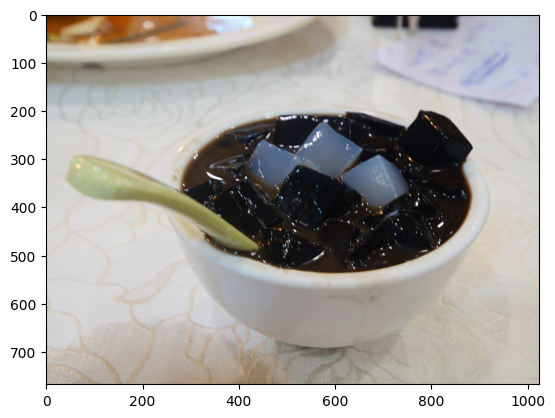

In [29]:
lang_style, lang_name, lang_code = language_list[0]
do_generate(print_img=True)

In [30]:
for lang_style, lang_name, lang_code in language_list:
    if lang_name in ["Hokkien", "Balinese"]:
        continue
    do_generate()

===== English =====
I found this dish at a Chinese restaurant. What is it called?
  (0) Tee long pan
  (1) Yusheng
  (2) Grass jelly
  (3) Bakpia
  (4) Youtiao

===== Indonesian (Formal) =====
Saya menemukan hidangan ini di restoran hidangan Tionghoa. Disebut apakah ini?
  (0) Yee sang
  (1) Cincau
  (2) Bakpia
  (3) Cahkwe
  (4) Kuaci

===== Indonesian (Casual) =====
Aku ketemu makanan ini di resto masakan Tionghoa. Sebutannya apa?
  (0) Yee sang
  (1) Cincau
  (2) Bakpia
  (3) Cahkwe
  (4) Kuaci

===== Chinese (Mandarin) =====
我在中国菜餐厅看到这道菜。它叫什么？
  (0) 腸粉
  (1) 撈魚生
  (2) 燒仙草
  (3) 侯皮亞
  (4) 油条

===== Korean (Formal) =====
저는 중국 음식점에서 이 음식을 발견했어요. 이 음식을 뭐라고 부르나요?
  (0) 청판
  (1) 위상
  (2) 선초 젤리
  (3) 유탸오
  (4) 박소

===== Korean (Casual) =====
나는 중국 음식점에서 이 음식을 발견했어. 이 음식을 뭐라고 불러?
  (0) 청판
  (1) 위상
  (2) 선초 젤리
  (3) 유탸오
  (4) 박소

===== Japanese (Formal) =====
私はこの料理を中国レストランで見つけました。これは何と呼ばれている料理ですか?
  (0) 腸粉
  (1) 仙草ゼリー
  (2) 油条
  (3) バクソ
  (4) チャーシュー

===== Japanese (Casual) =====
中国レストランで